### paths

In [1]:
import os
import sys
import numpy as np

proj_base_path = '../../'
data_base_path = '../../datasets'
models_base_path = '../../pretrained_models'
sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon_clustered_time_no_transp/meta/'
word_vectors_file = '_word_vectors_5000_ignore_ratio=0.05.wv'
duration_dict_file = 'durations_dict.json'

word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)
duration_dict_path = os.path.join(data_base_path, dataset_path, duration_dict_file)

### loading embedding

In [2]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load(word_vectors_path, mmap='r')

In [3]:
import json

with open(duration_dict_path) as fp:
    duration_dict = json.load(fp)

### loading model

In [4]:
from tensorflow import keras as K

model_dir = 'lstm_clustered_time/pokemon_no_transp_64/'
model_file = 'model_last_cpu.h5'
model = K.models.load_model(os.path.join(models_base_path, model_dir, model_file))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### creating output dir

In [5]:
output_dir = os.path.join(models_base_path, model_dir, 'samples')
os.makedirs(output_dir, exist_ok=True)

print(f'saving samples to {output_dir}')

saving samples to ../../pretrained_models/lstm_clustered_time/pokemon_no_transp_64/samples


### importing and preparing seed generators

In [6]:
from src.generating.embedded_clustered_time_generating_seeds import get_seed_generators

seed_generators = get_seed_generators(duration_dict, ignore_shortest=True)

seed_gens = [
    ('random_noise_seed', lambda length, input_size, wv, batch_size: seed_generators['random_noise_seed'](
        length, input_size, batch_size=batch_size)),
    ('zero_seed', lambda length, input_size, wv, batch_size: seed_generators['zero_seed'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('const_frame_seed', lambda length, input_size, wv, batch_size: seed_generators['const_frame_seed'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_seed', lambda length, input_size, wv, batch_size: seed_generators['multi_note_seed'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_harmonic_seed', lambda length, input_size, wv, batch_size: seed_generators['multi_note_harmonic_seed'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    
    ('const_frame_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['const_frame_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['multi_note_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_harmonic_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['multi_note_harmonic_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
]

### defining generating constants

In [7]:
from src.data_processing.common.rw_np_mid import read_numpy_midi, save_numpy_midi
from src.generating.generating import recurrent_generate
from src.data_processing.sparse_notes_classified_time.np2mid import np2sparse, np2mid
from src.data_processing.sparse_notes_classified_time.embed_adapt import decode_note_vector_track
import matplotlib.pyplot as plt
from time import time
from datetime import datetime

In [15]:
SEED_LENGTH = 5
SEQ_LENGTH = 200
INPUT_SIZE = 16
WINDOW_SIZE = 50
BATCH_SIZE = 1

In [16]:
seed_per_gen = [gen(SEED_LENGTH, INPUT_SIZE, wv, BATCH_SIZE) for _, gen in seed_gens]
samples_per_gen = [
    recurrent_generate(
        model,
        seed,
        SEQ_LENGTH,
        WINDOW_SIZE,
        is_binary=False,
        transform_input=lambda x: (x[:, :, :INPUT_SIZE], x[:, :, INPUT_SIZE:]),
        transform_output=lambda args: np.concatenate((args[0], args[1]), axis=2),
    ) for seed in seed_per_gen
]

In [17]:
sparse_samples_per_gen = [[
    np2sparse(
        decode_note_vector_track(s[:, :INPUT_SIZE], wv, return_similarities=False),
        s[:, INPUT_SIZE:],
        duration_dict,
        ppq=20,
    ) for s in samples
] for samples in samples_per_gen]

midis_per_gen = [[
    np2mid(
        decode_note_vector_track(s[:, :INPUT_SIZE], wv, return_similarities=False),
        s[:, INPUT_SIZE:],
        duration_dict,
    ) for s in samples
] for samples in samples_per_gen]

Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 151 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 151 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)
Encountered 0 unknowns per 155 (0%)


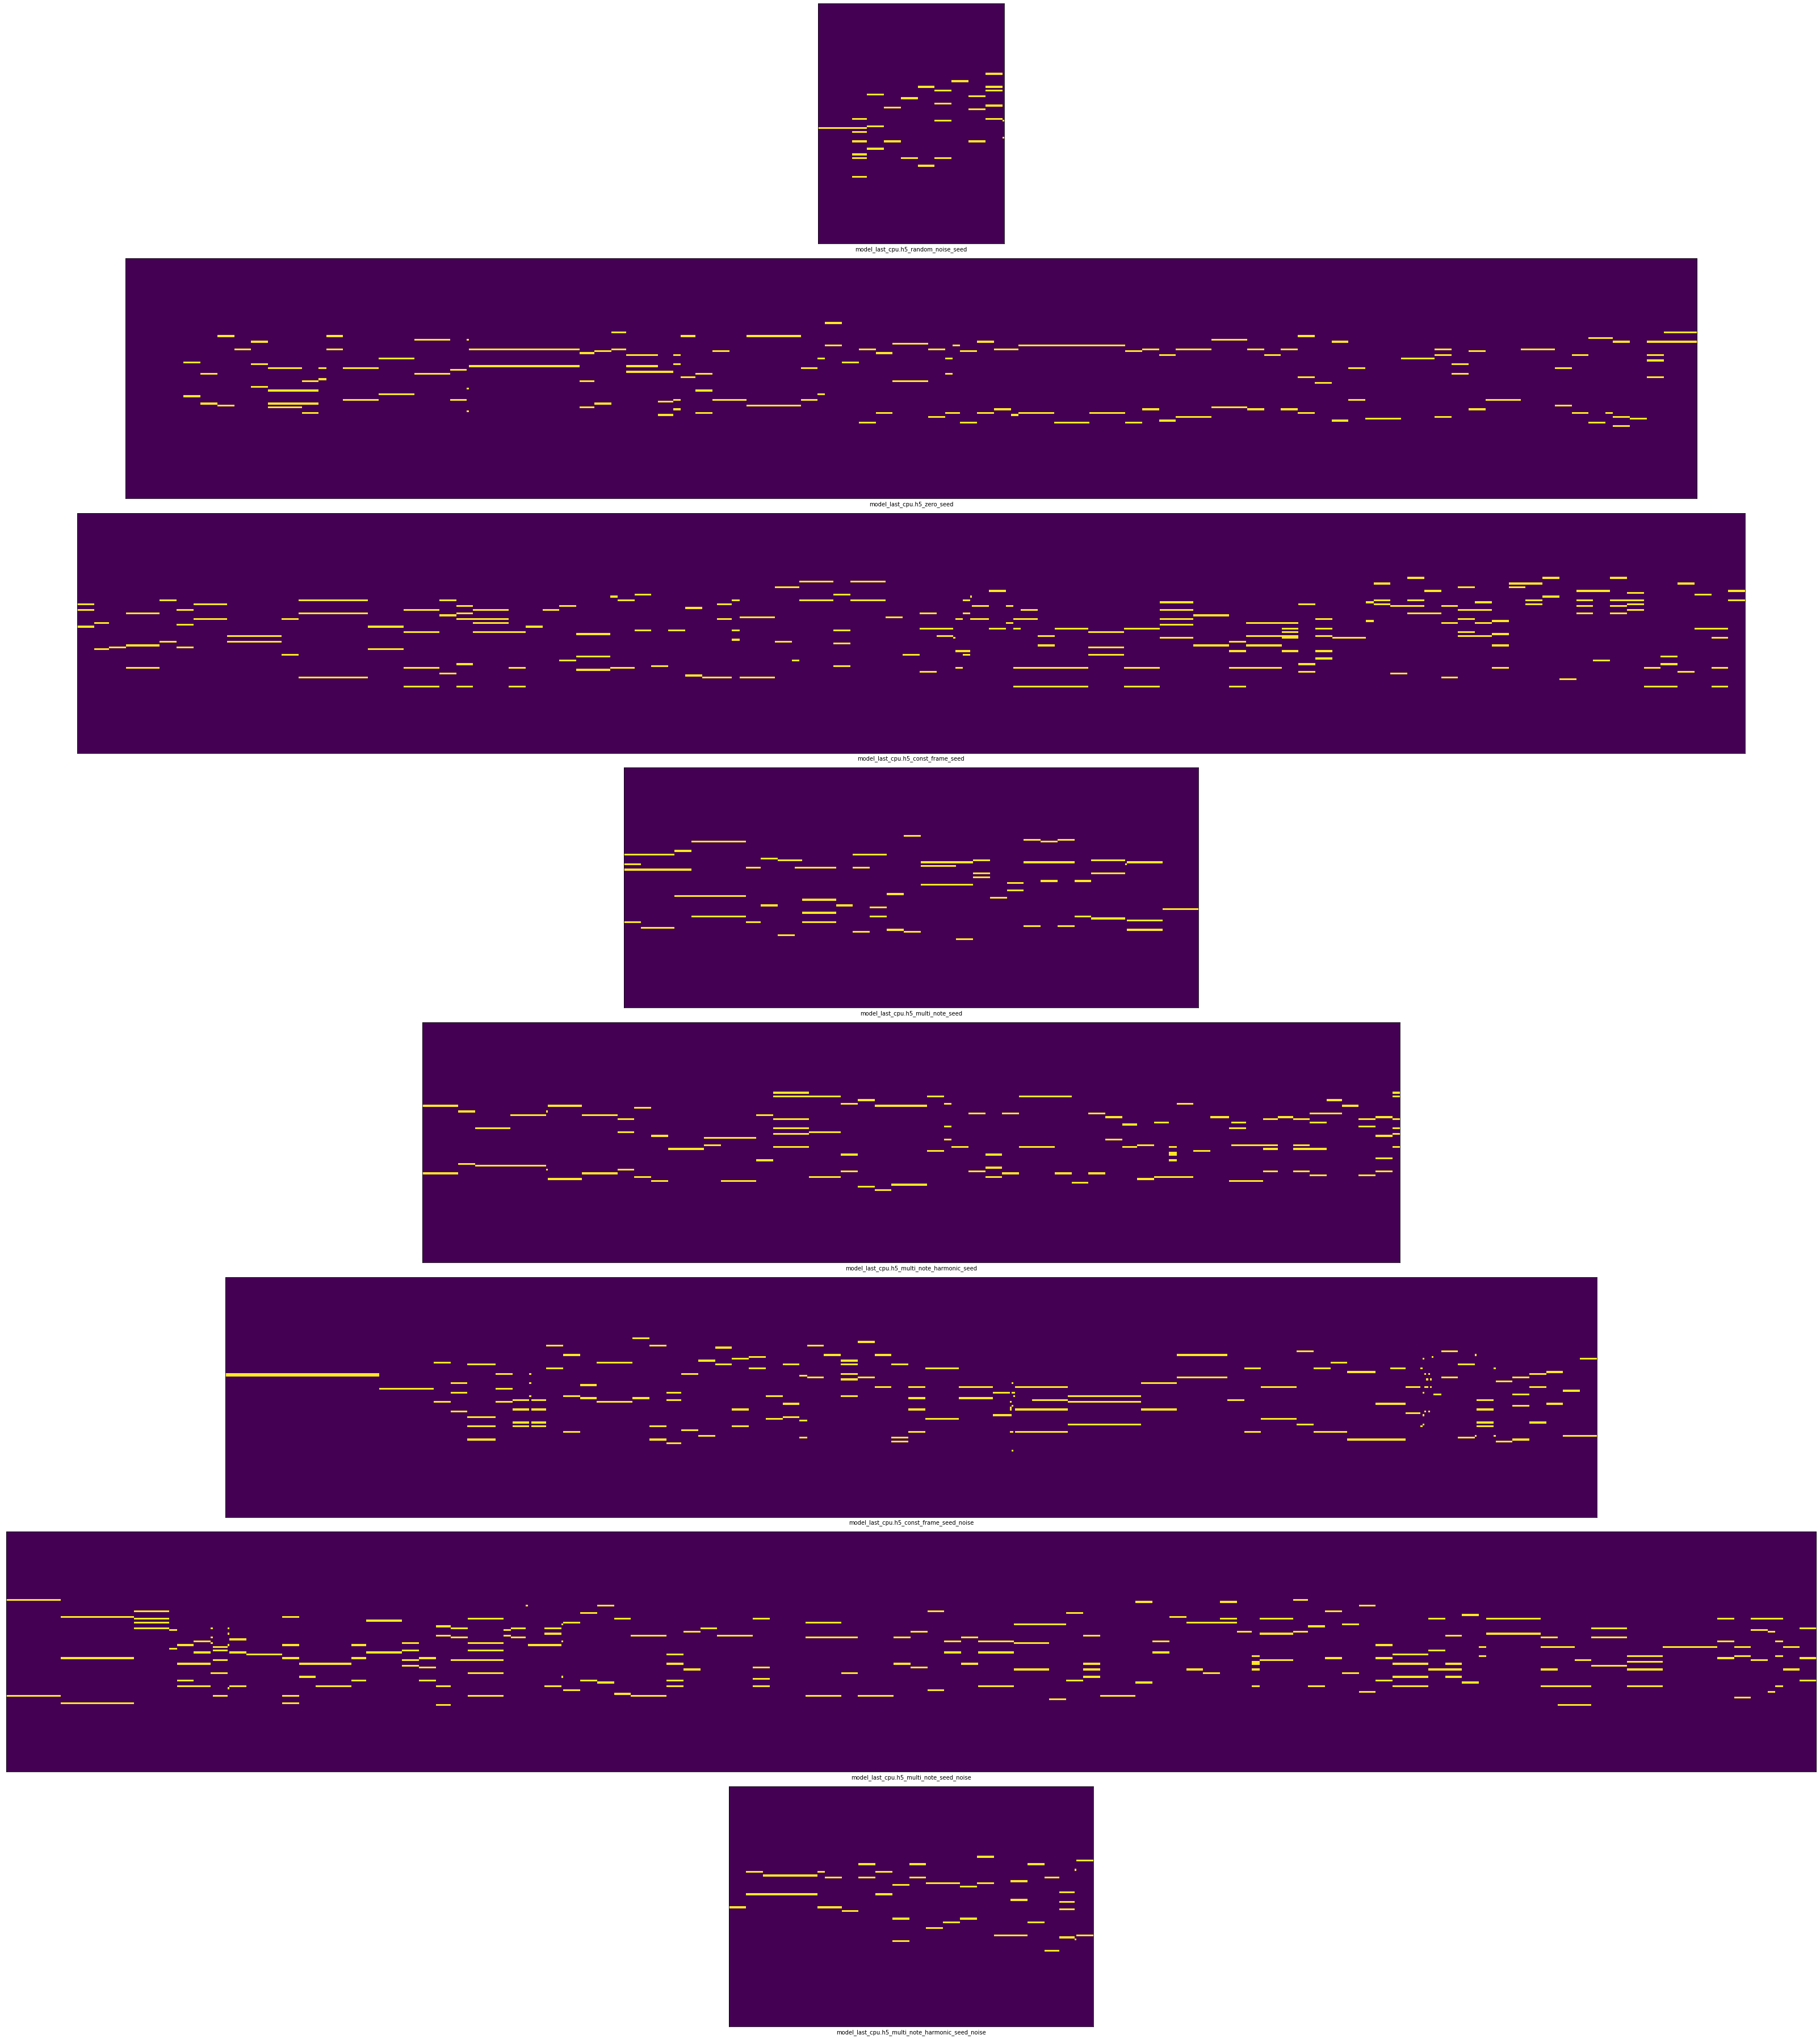

In [18]:
threshold = 0.5

gen_time = datetime.now().isoformat().split('.')[0]

_, axs = plt.subplots(nrows=len(seed_gens), ncols=BATCH_SIZE, figsize=(50, 50),
                          subplot_kw={'xticks': [], 'yticks': []})

for j, ((gen_name, _), sparse_samples) in enumerate(zip(seed_gens, sparse_samples_per_gen)):
    axs.flat[j * BATCH_SIZE].set(xlabel=f'{model_file}_{gen_name}')

    for i, sample in enumerate(sparse_samples):
        name = f'{model_file}_{gen_name}_{gen_time}_{i}'
        axs.flat[j * BATCH_SIZE + i].imshow(np.where(sample.T[::-1, :] > threshold, 1, 0))

plt.tight_layout()
fig = plt.gcf()

In [19]:
output_dir_ = os.path.join(output_dir, gen_time)
os.makedirs(output_dir_, exist_ok=True)

In [20]:
plot_name = f'{model_file}_{gen_time}'
fig.savefig(os.path.join(output_dir_, f'{plot_name}.png'), dpi=fig.dpi)

In [21]:
for (gen_name, _), midis in zip(seed_gens, midis_per_gen):
    for i, mid in enumerate(midis):
        name = f'{model_file}_{gen_name}_{gen_time}_{i}.mid'
        mid.save(os.path.join(output_dir_, name))